In [21]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Administrator\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [22]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Administrator\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


         ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1000001         1         S1            L3          R1  2018-01-01   
1  T1000002       253         S4            L2          R1  2018-01-01   
2  T1000003       252         S3            L2          R1  2018-01-01   
3  T1000004       251         S2            L3          R1  2018-01-01   
4  T1000005       250         S2            L3          R4  2018-01-01   

   Holiday Discount  #Order     Sales  
0        1      Yes       9   7011.84  
1        1      Yes      60  51789.12  
2        1      Yes      42  36868.20  
3        1      Yes      23  19715.16  
4        1      Yes      62  45614.52  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     1883

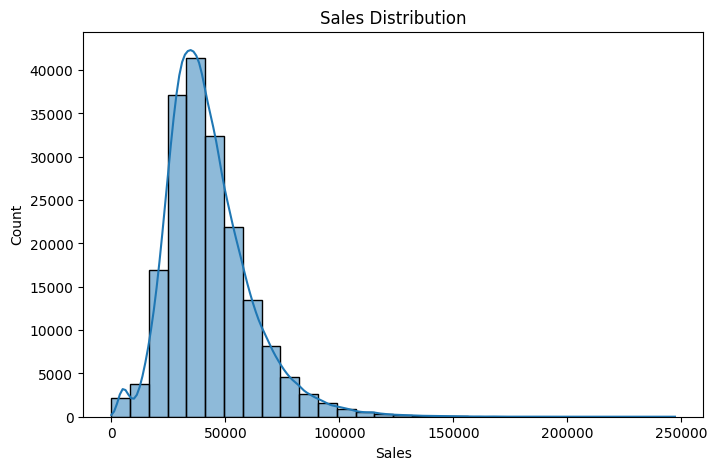

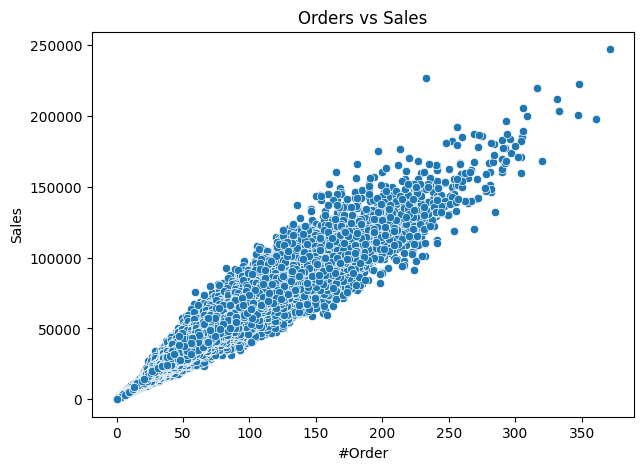

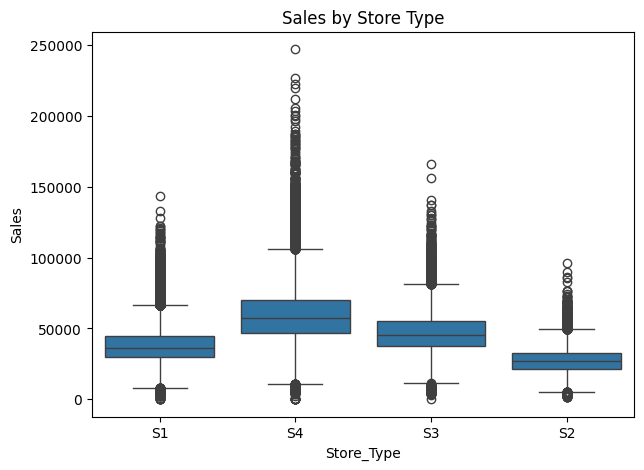

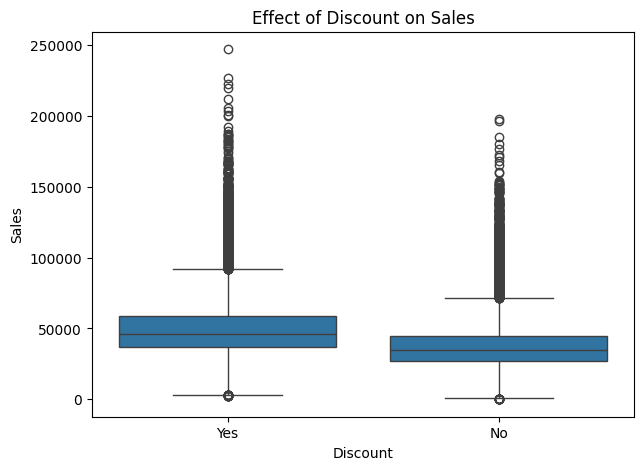

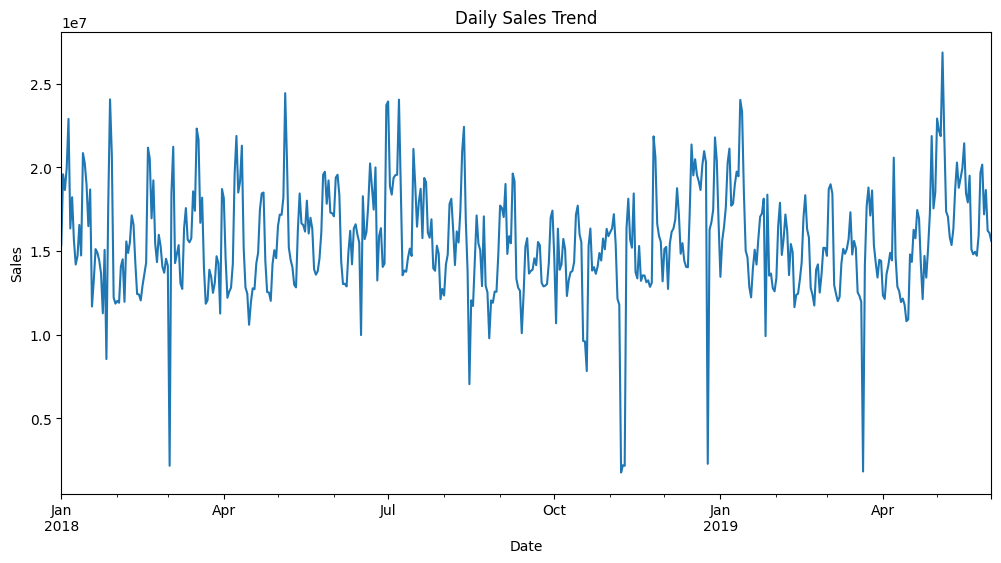

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv(r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data\TRAIN.csv")

# Basic overview
print(train.head())
print(train.info())
print(train.describe())

# Convert Date column
train['Date'] = pd.to_datetime(train['Date'])

# Check missing values
print(train.isnull().sum())

# Plot sales distribution
plt.figure(figsize=(8,5))
sns.histplot(train['Sales'], bins=30, kde=True)
plt.title("Sales Distribution")
plt.show()

# Orders vs Sales
plt.figure(figsize=(7,5))
sns.scatterplot(data=train, x="#Order", y="Sales")
plt.title("Orders vs Sales")
plt.show()

# Categorical sales comparison
plt.figure(figsize=(7,5))
sns.boxplot(data=train, x="Store_Type", y="Sales")
plt.title("Sales by Store Type")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=train, x="Discount", y="Sales")
plt.title("Effect of Discount on Sales")
plt.show()

# Time Series Trend
daily_sales = train.groupby("Date")["Sales"].sum()

plt.figure(figsize=(12,6))
daily_sales.plot()
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


Product Sales Forecasting — Level B

Goal: Forecast Sales using tabular ML (LightGBM).
Environment / paths: Windows; data at C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data\TRAIN.csv and TEST_FINAL.csv.

In [24]:
# CODE: 00 - Setup & imports
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ML
from lightgbm import LGBMRegressor


01 — Load the data (use your path)

In [25]:
# CODE: 01 - Paths and load
DATA_DIR = r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data"
TRAIN_PATH = os.path.join(DATA_DIR, "TRAIN.csv")
TEST_PATH  = os.path.join(DATA_DIR, "TEST_FINAL.csv")

print("Train path:", TRAIN_PATH)
print("Test path :", TEST_PATH)

train = pd.read_csv(TRAIN_PATH)
# if you want to preview test file too (optional)
# test = pd.read_csv(TEST_PATH)

train.shape


Train path: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data\TRAIN.csv
Test path : C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data\TEST_FINAL.csv


(188340, 10)

02 — Quick data overview

In [26]:
# CODE: 02 - head, info, describe
display(train.head(10))
print("\n--- dtypes ---")
print(train.dtypes)
print("\n--- missing values ---")
print(train.isnull().sum())
print("\n--- basic stats ---")
display(train.describe(include='all').T)


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52
5,T1000006,249,S1,L3,R2,2018-01-01,1,Yes,39,34211.22
6,T1000007,248,S1,L1,R2,2018-01-01,1,Yes,40,35352.66
7,T1000008,247,S1,L1,R3,2018-01-01,1,Yes,64,52650.00
8,T1000009,246,S3,L1,R3,2018-01-01,1,Yes,62,42633.78
9,T1000010,254,S4,L1,R1,2018-01-01,1,Yes,87,62572.80



--- dtypes ---
ID                object
Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount          object
#Order             int64
Sales            float64
dtype: object

--- missing values ---
ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

--- basic stats ---


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,188340,188340,T1188340,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store_id,188340.0,NaN,NaN,NaN,183.0,105.366308,1.0,92.0,183.0,274.0,365.0
Store_Type,188340,4,S1,88752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location_Type,188340,5,L1,85140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region_Code,188340,4,R1,63984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,188340,516,2019-05-31,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday,188340.0,NaN,NaN,NaN,0.131783,0.338256,0.0,0.0,0.0,0.0,1.0
Discount,188340,2,No,104051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#Order,188340.0,NaN,NaN,NaN,68.205692,30.467415,0.0,48.0,63.0,82.0,371.0
Sales,188340.0,NaN,NaN,NaN,42784.327982,18456.708302,0.0,30426.0,39678.0,51909.0,247215.0


03 — Clean & fix basic types (Date parsing, strip strings)

In [27]:
# CODE: 03 - Clean basics

# Trim string columns (defensive)
for c in train.select_dtypes(include=['object']).columns:
    train[c] = train[c].astype(str).str.strip()

# Parse Date (robust)
train['Date'] = pd.to_datetime(train['Date'], errors='coerce')

# Check how many dates failed to parse
bad_dates = train['Date'].isnull().sum()
print("Failed to parse Date:", bad_dates)

# If there are bad date rows, inspect them
if bad_dates:
    display(train[train['Date'].isnull()].head(10))


Failed to parse Date: 0


04 — Handle missing values (simple, transparent)

For this project we'll drop rows with missing target (Sales) or missing crucial features like Store_id or Date.

For other missing values we'll use simple imputation / fill strategies and note them in the notebook.

In [28]:
# CODE: 04 - Missing handling
print("Missing before:", train.isnull().sum())

# Drop rows where Sales or Store_id or Date are missing (can't model without these)
train = train.dropna(subset=['Sales', 'Store_id', 'Date']).copy()

# For categorical missing, fill with 'Unknown' (if any)
cat_cols = ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']
for c in cat_cols:
    if c in train.columns:
        train[c] = train[c].fillna('Unknown')

# For Holiday, make sure it's numeric 0/1
if 'Holiday' in train.columns:
    # coerce to numeric and fillna with 0
    train['Holiday'] = pd.to_numeric(train['Holiday'], errors='coerce').fillna(0).astype(int)

print("\nMissing after:")
print(train.isnull().sum())


Missing before: ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

Missing after:
ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64


05 — Exploratory Data Analysis (plots + insights)

Distribution of target

Orders vs Sales

Boxplots for categorical variables

Time-series aggregate (daily sales)

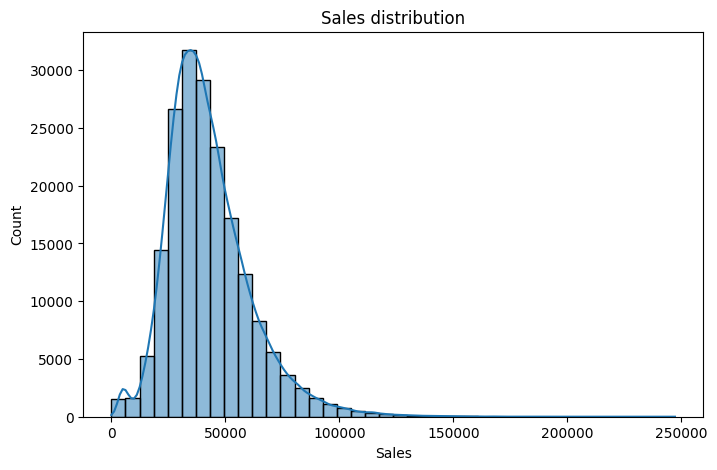

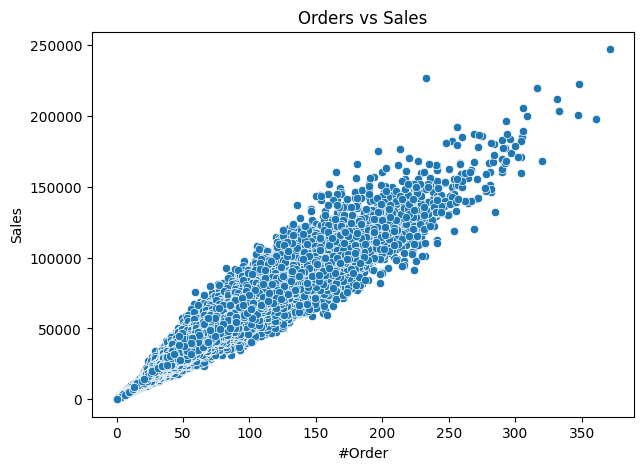

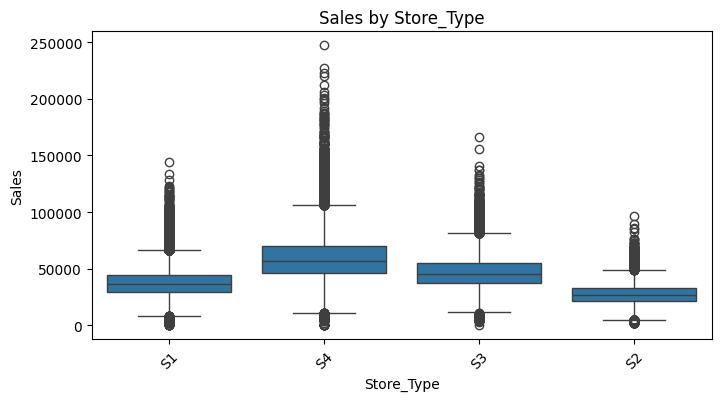

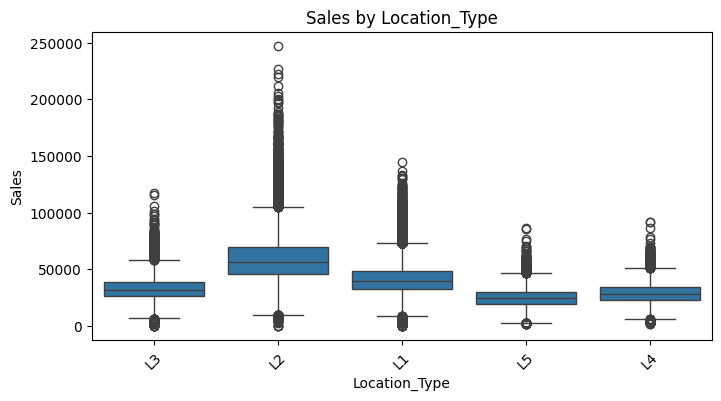

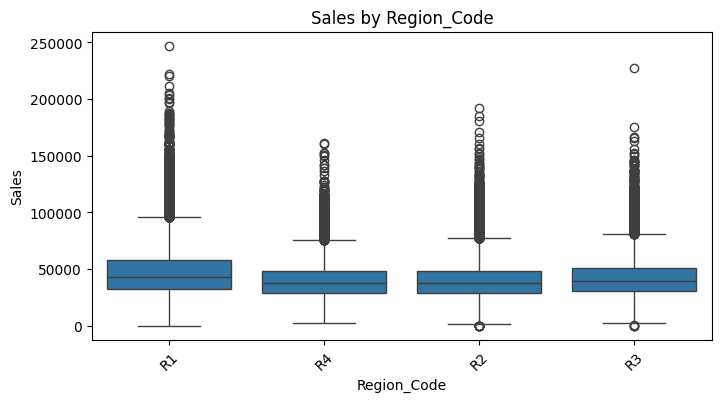

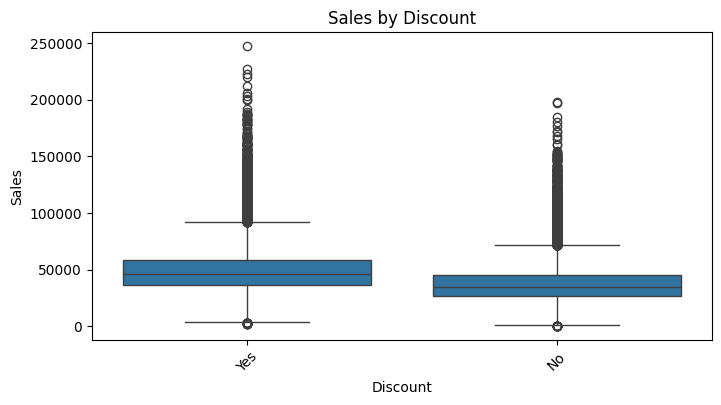

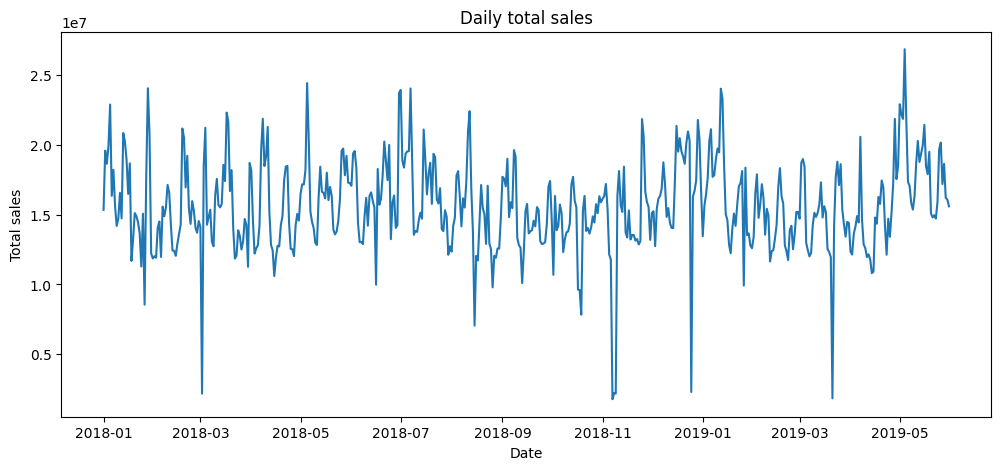

In [29]:
# CODE: 05 - EDA plots
plt.figure(figsize=(8,5))
sns.histplot(train['Sales'], bins=40, kde=True)
plt.title("Sales distribution")
plt.xlabel("Sales")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x=train["#Order"], y=train["Sales"])
plt.title("Orders vs Sales")
plt.xlabel("#Order")
plt.ylabel("Sales")
plt.show()

# Categorical boxplots (if present)
for c in ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']:
    if c in train.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=train, x=c, y='Sales')
        plt.title(f"Sales by {c}")
        plt.xticks(rotation=45)
        plt.show()

# Time series: daily total sales
daily = train.groupby('Date')['Sales'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.plot(daily['Date'], daily['Sales'])
plt.title("Daily total sales")
plt.xlabel("Date")
plt.ylabel("Total sales")
plt.show()


06 — Hypothesis testing (stat tests)

Discount vs no-discount

Holiday vs non-holiday

ANOVA for store types

In [30]:
# CODE: 06 - Hypothesis tests
from scipy.stats import ttest_ind, f_oneway

# Discount effect
if 'Discount' in train.columns:
    a = train[train['Discount'].str.lower()=='yes']['Sales']
    b = train[train['Discount'].str.lower()!='yes']['Sales']
    if len(a)>10 and len(b)>10:
        t, p = ttest_ind(a, b, equal_var=False)
        print("Discount vs No-discount t-test p-value:", p)
    else:
        print("Not enough samples for Discount test")

# Holiday effect
if 'Holiday' in train.columns:
    a = train[train['Holiday']==1]['Sales']
    b = train[train['Holiday']==0]['Sales']
    if len(a)>10 and len(b)>10:
        t, p = ttest_ind(a, b, equal_var=False)
        print("Holiday vs Non-holiday t-test p-value:", p)
    else:
        print("Not enough samples for Holiday test")

# Store_Type ANOVA
if 'Store_Type' in train.columns:
    groups = [g['Sales'].values for _, g in train.groupby('Store_Type') if len(g)>5]
    if len(groups) >= 2:
        F, p = f_oneway(*groups)
        print("Store_Type ANOVA p-value:", p)


Discount vs No-discount t-test p-value: 0.0
Holiday vs Non-holiday t-test p-value: 0.0
Store_Type ANOVA p-value: 0.0


07 — Feature engineering

Extract date parts

Simple lag/rolling features (if possible)

Encode categoricals with LabelEncoder (LightGBM handles categorical but we’ll encode for safety)

In [31]:
# CODE: 07 - Feature engineering
df = train.copy()

# Date parts
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)

# Create average sales per store (historical aggregate) - useful feature
store_agg = df.groupby('Store_id')['Sales'].agg(['mean','median','std']).reset_index().rename(columns={'mean':'store_sales_mean','median':'store_sales_median','std':'store_sales_std'})
df = df.merge(store_agg, on='Store_id', how='left')

# If dataset is big and date-sorted, we could create lag features. For simplicity create a rolling mean per store (7-day)
df = df.sort_values(['Store_id','Date'])
df['store_7d_avg'] = df.groupby('Store_id')['Sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())

# Fill any remaining na in numeric engineered features
num_fill_cols = ['store_sales_std','store_7d_avg']
for c in num_fill_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Encode categorical columns
cat_cols = ['Store_Type','Location_Type','Region_Code','Discount']
le_dict = {}
for c in cat_cols:
    if c in df.columns:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        le_dict[c] = le  # save encoder in dict (useful later)
        
# Show final feature list
exclude = ['ID','Sales','Date']  # don't use these as features
features = [c for c in df.columns if c not in exclude]
print("Features used:", features)


Features used: ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', '#Order', 'Year', 'Month', 'Day', 'Weekday', 'Week', 'store_sales_mean', 'store_sales_median', 'store_sales_std', 'store_7d_avg']


08 — Train/test split and LightGBM training

In [33]:
# df must already exist from feature engineering
# If df doesn't exist, you must run the feature engineering block before this one.

# These two variables MUST be created before train/test split:
X = df[features].copy()
y = df['Sales'].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (188340, 16)
y shape: (188340,)


In [34]:
# Train–test split block (MUST RUN BEFORE MODEL TRAINING)

# X and y must already be created earlier via:
# X = df[features]
# y = df["Sales"]

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (150672, 16)
X_val shape: (37668, 16)
y_train shape: (150672,)
y_val shape: (37668,)


In [37]:
# FINAL COMPATIBLE TRAINING BLOCK for older LightGBM versions

# Convert y to numpy arrays
y_train_np = y_train.to_numpy()
y_val_np   = y_val.to_numpy()

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Old LGBM versions accept only X, y — NO eval_set, NO callbacks, NO verbose
model.fit(X_train, y_train_np)

# Make validation predictions manually
pred_val = model.predict(X_val)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_val_np, pred_val)
rmse = np.sqrt(mean_squared_error(y_val_np, pred_val))

print("MAE:", mae)
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 16
[LightGBM] [Info] Start training from score 42751.955303
MAE: 1237.7533575178327
RMSE: 1757.5267893182022


09 — Evaluate model

MAE, RMSE, R2

Plot predicted vs actual

Feature importance

MAE: 1237.75
RMSE: 1757.53
R2: 0.9912


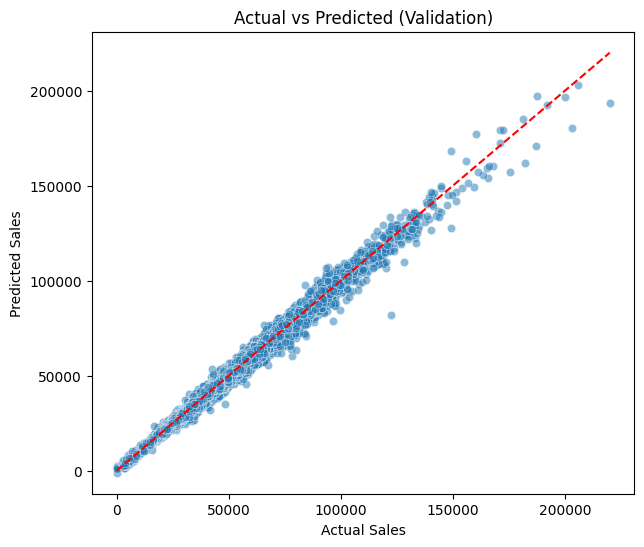

,feature,importance
6,#Order,2857
12,store_sales_mean,1706
11,Week,1385
14,store_sales_std,1379
0,Store_id,1340
13,store_sales_median,938
9,Day,707
5,Discount,687
15,store_7d_avg,679
10,Weekday,608


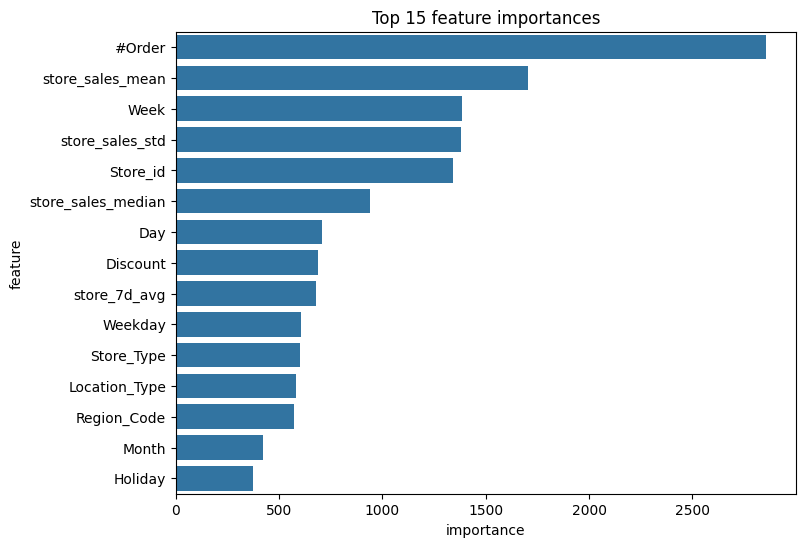

In [38]:
# CODE: 09 - Evaluation
pred_val = model.predict(X_val)
mae = mean_absolute_error(y_val, pred_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2 = r2_score(y_val, pred_val)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")

# Pred vs actual plot
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_val, y=pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted (Validation)")
plt.show()

# Feature importance
fi = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
display(fi.head(25))

plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(15), x='importance', y='feature')
plt.title("Top 15 feature importances")
plt.show()


10 — Save the model & encoders


In [39]:
# CODE: 10 - Save model and encoders
OUT_DIR = r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUT_DIR, "sales_model.pkl")
ENC_PATH   = os.path.join(OUT_DIR, "label_encoders.pkl")

joblib.dump(model, MODEL_PATH)
joblib.dump(le_dict, ENC_PATH)

print("Saved model to:", MODEL_PATH)
print("Saved encoders to:", ENC_PATH)


Saved model to: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model\sales_model.pkl
Saved encoders to: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model\label_encoders.pkl


11 — Predict on TEST_FINAL (if present) and prepare submission

In [41]:
# FIXED: safe test preprocessing + prediction (paste & run this cell)
import os
import numpy as np
import pandas as pd

# ---- locate model feature order ----
if 'X_train' in globals():
    model_features = list(X_train.columns)
elif 'features' in globals():
    model_features = list(features)
else:
    raise RuntimeError("Can't find training feature list. Ensure X_train or features exists in this notebook.")

# ---- load test if not in session ----
TEST_PATH = os.path.join(r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data", "TEST_FINAL.csv")
if 'test' not in globals():
    if os.path.exists(TEST_PATH):
        test = pd.read_csv(TEST_PATH)
    else:
        raise FileNotFoundError(f"TEST_FINAL.csv not found at {TEST_PATH}")

# Make a working copy
test_proc = test.copy()

# Parse Date if present and create date parts (same as training)
if 'Date' in test_proc.columns:
    test_proc['Date'] = pd.to_datetime(test_proc['Date'], errors='coerce')
    test_proc['Year'] = test_proc['Date'].dt.year
    test_proc['Month'] = test_proc['Date'].dt.month
    test_proc['Day'] = test_proc['Date'].dt.day
    test_proc['Weekday'] = test_proc['Date'].dt.weekday
    # week may be missing on older pandas; wrap safely
    try:
        test_proc['Week'] = test_proc['Date'].dt.isocalendar().week.astype(int)
    except Exception:
        test_proc['Week'] = test_proc['Date'].dt.week

# ---- apply saved label encoders if available ----
# prefer le_dict (notebook) else try to load encoders file created earlier
encoders = None
if 'le_dict' in globals():
    encoders = le_dict
else:
    enc_path = r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model\label_encoders.pkl"
    if os.path.exists(enc_path):
        encoders = joblib.load(enc_path)

if encoders:
    for col, le in encoders.items():
        if col in test_proc.columns:
            # coerce to str, map unseen -> 'Unknown' (ensure encoder has Unknown)
            vals = test_proc[col].astype(str).fillna('Unknown').tolist()
            # add Unknown to classes_ if missing (safe)
            if 'Unknown' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'Unknown')
            mapped = [v if v in le.classes_ else 'Unknown' for v in vals]
            test_proc[col] = le.transform(mapped)
# ---- for any remaining object/string columns that are in model_features, label-factorize them ----
for c in model_features:
    if c in test_proc.columns and test_proc[c].dtype == 'O':
        # convert to numeric by factorize (stable within this run)
        test_proc[c] = pd.factorize(test_proc[c].astype(str))[0]

# ---- ensure engineered numeric features exist (safe defaults) ----
for col in ['store_sales_mean','store_sales_median','store_sales_std','store_7d_avg']:
    if col in model_features and col not in test_proc.columns:
        test_proc[col] = 0

# ---- ensure all model_features exist in test_proc; if missing, add zeros ----
missing = [c for c in model_features if c not in test_proc.columns]
for c in missing:
    test_proc[c] = 0

# ---- drop extra columns that are not needed (but keep ID for output) ----
keep_cols = [c for c in test_proc.columns if c in model_features or c in ['ID','Date','Sales']]
test_proc = test_proc[keep_cols]

# ---- reorder to model_features exactly ----
test_X = test_proc.reindex(columns=model_features, fill_value=0)

# final dtype safety: convert all to numeric
for col in test_X.columns:
    if test_X[col].dtype == 'O':
        test_X[col] = pd.to_numeric(test_X[col].astype(str).replace('','0'), errors='coerce').fillna(0)

# ---- sanity check shape ----
if test_X.shape[1] != getattr(model, "_n_features", test_X.shape[1]):
    raise ValueError(f"After alignment, input n_features is {test_X.shape[1]} but model expects {model._n_features}.")

# ---- predict ----
preds_test = model.predict(test_X)
test['Predicted_Sales'] = preds_test

# ---- save submission ----
out_path = os.path.join(r"C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data", "submission_test_pred.csv")
test[['ID','Predicted_Sales']].to_csv(out_path, index=False)
print("Saved test predictions to:", out_path)
display(test[['ID','Predicted_Sales']].head())


Saved test predictions to: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\data\submission_test_pred.csv


,ID,Predicted_Sales
0,T1188341,6433.189444
1,T1188342,6441.949555
2,T1188343,6128.873853
3,T1188344,6531.527434
4,T1188345,6305.785913


12 — Notes / next steps (what to include in report & Tableau)

Add short write-up: problem, dataset, EDA highlights, modeling approach, metrics (MAE/RMSE), conclusions.

Tableau: create dashboards showing time series, sales by Store_Type, Discount vs Sales, Forecast vs Actual.

Deployment: use saved sales_model.pkl + label_encoders.pkl in a Flask app (I’ll supply app.py code below).

In [42]:
# CODE: 13 - Print final locations for convenience
print("Notebook done. Model at:", MODEL_PATH)
print("Encoders at:", ENC_PATH)
print("If you want app.py and requirements.txt contents paste the following to files.")


Notebook done. Model at: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model\sales_model.pkl
Encoders at: C:\Users\Administrator\Desktop\Product-Sales-Forecasting\model\label_encoders.pkl
If you want app.py and requirements.txt contents paste the following to files.


In [43]:
print(list(X_train.columns))
print("Total features:", len(X_train.columns))



['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', '#Order', 'Year', 'Month', 'Day', 'Weekday', 'Week', 'store_sales_mean', 'store_sales_median', 'store_sales_std', 'store_7d_avg']
Total features: 16
